# **Project Title: Amazon Retail Sales Forecasting and Business Insight Generation**

by **Prithvi Saran Sathyasaran (G44070057)**

## Objective:
This project aims to **analyze and forecast sales trends** using Amazon's retail transaction data. The focus is on building machine learning models to predict future demand and extract actionable insights that can support strategic retail decisions.

## Dataset:
- Source: [Amazon Sales Report – Kaggle](https://www.kaggle.com/datasets/mdsazzatsardar/amazonsalesreport)
- Time Period: April 2022 (daily transaction records)
- Key Columns: `Date`, `SKU`, `Category`, `Qty`, `Amount`, `Status`

## Key Goals:
- Predict future product sales using machine learning
- Identify top-selling products and categories
- Recommend optimal days for shop openings
- Detect underperforming time windows (closure signals)
- Provide visual insights to assist business planning

## Technologies Used:
- **Python**, **Pandas**, **Seaborn**, **Matplotlib**
- **Scikit-learn**, **XGBoost**, **GridSearchCV**
- Environment: **Google Colab**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# dataset loaded from kaggle
path = "/content/drive/MyDrive/Retail_Sales_Forecasting_Project/"
df = pd.read_csv(path + "Amazon_Sale_Report.csv", low_memory=False)
df.head(5)




,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


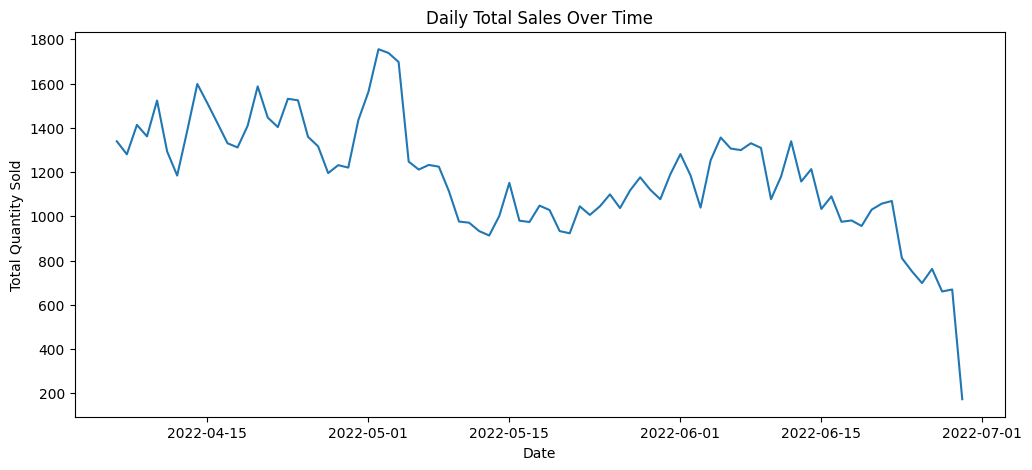

In [ ]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_sales, x='Date', y='Total_Qty')
plt.title("Daily Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Quantity Sold")
plt.show()

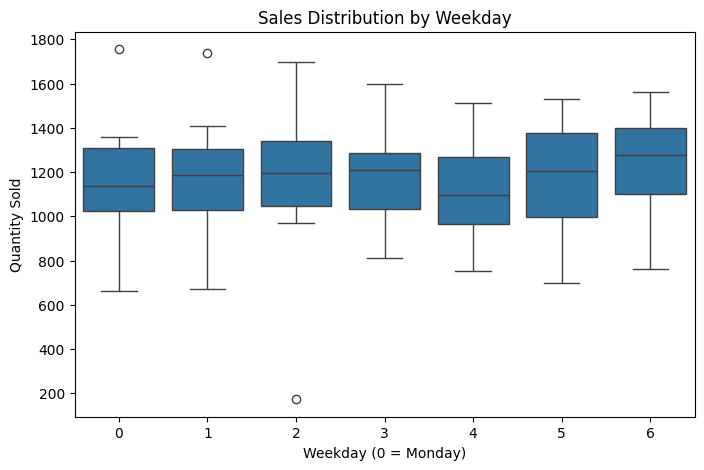

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=daily_sales, x='Weekday', y='Total_Qty')
plt.title("Sales Distribution by Weekday")
plt.xlabel("Weekday (0 = Monday)")
plt.ylabel("Quantity Sold")
plt.show()

The dataset contains individual sales records, including `Date`, `Product Name`, `Qty`, `Category`, `Rate`, `Tax`, and `Total Amount`.
We will focus on the `Date`, `Qty`, and `Category` fields for forecasting monthly sales volume.


## **Clean the Data and Format Dates**

We remove rows with missing quantity or date values. We also convert the Date column into a datetime format and set it as the index to enable time series processing.

In [ ]:
print(df.columns)

Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city',
       'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids',
       'B2B', 'fulfilled-by', 'Unnamed: 22'],
      dtype='object')


In [ ]:
columns_to_drop = ['index', 'Unnamed: 22', 'promotion-ids', 'fulfilled-by', 'Courier Status']
for col in columns_to_drop:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
df = df.dropna(subset=['Date', 'Qty'])

#date column converted to datetime required format
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y', errors='coerce')

df = df.dropna(subset=['Date'])

# 'Cancelled' status entries removed
valid_statuses = ["Shipped", "Shipped - Delivered to Buyer", "Delivered"]
df = df[df['Status'].isin(valid_statuses)]

df = df.sort_values('Date').reset_index(drop=True)

print("\n✅ Cleaned Dataset Info:")
print(df.info())

df_agg = df.copy()
df_agg.set_index('Date', inplace=True)

#monthly total quantity sold
monthly_sales = df_agg['Qty'].resample('ME').sum().reset_index()
monthly_sales.columns = ['Date', 'Total_Qty']

#monthly sales by category
monthly_sales_by_category = df_agg.groupby([pd.Grouper(freq='ME'), 'Category'])['Qty'].sum().unstack().fillna(0)

#preview
monthly_sales.head()



✅ Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106573 entries, 0 to 106572
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Order ID            106573 non-null  object        
 1   Date                106573 non-null  datetime64[ns]
 2   Status              106573 non-null  object        
 3   Fulfilment          106573 non-null  object        
 4   Sales Channel       106573 non-null  object        
 5   ship-service-level  106573 non-null  object        
 6   Style               106573 non-null  object        
 7   SKU                 106573 non-null  object        
 8   Category            106573 non-null  object        
 9   Size                106573 non-null  object        
 10  ASIN                106573 non-null  object        
 11  Qty                 106573 non-null  int64         
 12  currency            106357 non-null  object        
 13  Amou

,Date,Total_Qty
0,2022-03-31,151
1,2022-04-30,41183
2,2022-05-31,35522
3,2022-06-30,30039


## **Updated Monthly Sales Trends and Category Insights**

We explore sales trends with the following visualizations:
- Total monthly quantity sold
- Quantity sold by product category
- Missing values per column (from raw dataset)
- Top-selling products and revenue trends


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.



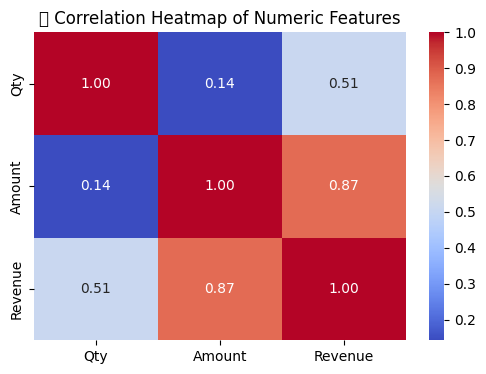

In [ ]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

raw_df = pd.read_csv(path + "Amazon_Sale_Report.csv", low_memory=False)

# Total Quantity Sold Per Month
fig_total = px.line(monthly_sales,
                    x='Date', y='Total_Qty',
                    title='Monthly Total Quantity Sold',
                    labels={'Date': 'Month', 'Total_Qty': 'Quantity Sold'})
fig_total.show()

# Quantity Sold by Category
category_df = monthly_sales_by_category.copy()
category_df['Month'] = category_df.index.strftime('%Y-%m')
category_df = category_df.reset_index(drop=True)
category_df = category_df.melt(id_vars='Month', var_name='Category', value_name='Quantity Sold')

fig_category = px.line(category_df,
                       x='Month', y='Quantity Sold', color='Category',
                       title='Monthly Quantity Sold by Category')
fig_category.show()

# Missing Values in Original Dataset
missing_counts = raw_df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

fig_missing = px.bar(missing_counts,
                     title="Missing Values per Column (Original Dataset)",
                     labels={'index': 'Column', 'value': 'Missing Count'})
fig_missing.show()

# Top 10 Best-Selling Products by Quantity
top_products = df.groupby('SKU')['Qty'].sum().sort_values(ascending=False).head(10)
fig_top_products = px.bar(top_products,
                          title='Top 10 Best-Selling Products (by SKU)',
                          labels={'index': 'Product SKU', 'value': 'Total Quantity'},
                          text=top_products.values)
fig_top_products.show()

# Scatter Plot: Quantity vs Revenue
df['Revenue'] = df['Qty'] * df['Amount']
fig_scatter = px.scatter(df, x='Qty', y='Revenue',
                         title='Quantity vs Revenue Distribution',
                         labels={'Qty': 'Quantity Sold', 'Revenue': 'Revenue'},
                         opacity=0.5,
                         trendline='ols')
fig_scatter.show()

# Correlation Heatmap
numeric_cols = df[['Qty', 'Amount', 'Revenue']]
corr = numeric_cols.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("🔗 Correlation Heatmap of Numeric Features")
plt.show()


# **Feature Engineering for Time-Series Forecasting**

We now prepare features like previous month's sales (lag), rolling averages, and extract time components to help models learn seasonal patterns.


In [ ]:
import pandas as pd

#daily aggregation
df_daily = df.copy()
df_daily['Date'] = pd.to_datetime(df_daily['Date'])
df_daily.set_index('Date', inplace=True)

daily_sales = df_daily['Qty'].resample('D').sum().reset_index()
daily_sales.columns = ['Date', 'Total_Qty']
daily_sales.set_index('Date', inplace=True)

#feature engineering
daily_sales['Lag_1'] = daily_sales['Total_Qty'].shift(1)
daily_sales['Rolling_7'] = daily_sales['Total_Qty'].rolling(window=7).mean()

#calendar features add
daily_sales['Day'] = daily_sales.index.day
daily_sales['Weekday'] = daily_sales.index.weekday  # 0=Monday, 6=Sunday
daily_sales['Month'] = daily_sales.index.month
daily_sales['Year'] = daily_sales.index.year

#rows with missing values from shift and rolling is dropped
daily_sales.dropna(inplace=True)
daily_sales.reset_index(inplace=True)

#displaying all rows
pd.set_option('display.max_rows', None)
daily_sales


,Date,Total_Qty,Lag_1,Rolling_7,Day,Weekday,Month,Year
0,2022-04-06,1339,1384.0,1152.285714,6,2,4,2022
1,2022-04-07,1280,1339.0,1313.571429,7,3,4,2022
2,2022-04-08,1413,1280.0,1341.714286,8,4,4,2022
3,2022-04-09,1361,1413.0,1351.714286,9,5,4,2022
4,2022-04-10,1523,1361.0,1364.857143,10,6,4,2022
5,2022-04-11,1293,1523.0,1370.428571,11,0,4,2022
6,2022-04-12,1184,1293.0,1341.857143,12,1,4,2022
7,2022-04-13,1387,1184.0,1348.714286,13,2,4,2022
8,2022-04-14,1598,1387.0,1394.142857,14,3,4,2022
9,2022-04-15,1511,1598.0,1408.142857,15,4,4,2022


# **Model Training & Evaluation**

We train multiple regression models using our engineered features and evaluate their performance using Mean Absolute Error (MAE):

- Linear Regression
- XGBoost
- Random Forest
- Decision Tree
- SVR
- K-Nearest Neighbors


Linear Regression → MAE: 119.17, RMSE: 164.91, R²: 0.5511 (55.11%)
XGBoost → MAE: 305.20, RMSE: 395.08
Random Forest → MAE: 219.49, RMSE: 309.87
Decision Tree → MAE: 224.18, RMSE: 303.58
SVR → MAE: 342.31, RMSE: 422.06
KNN → MAE: 210.46, RMSE: 290.72


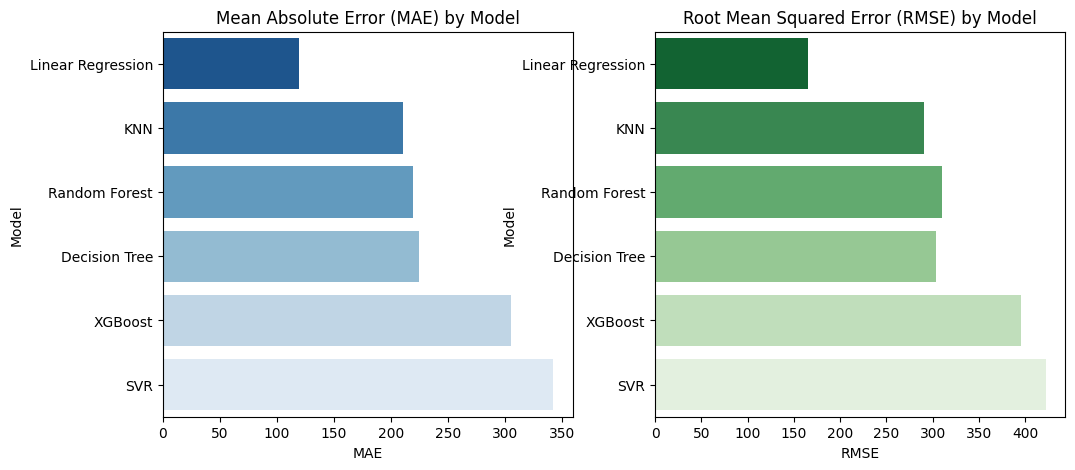

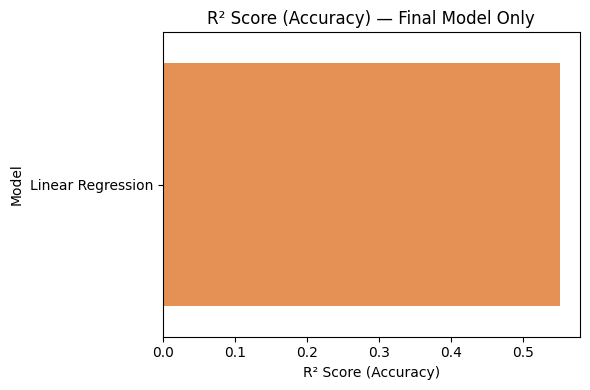

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

#Feature set from daily_sales
features = ['Lag_1', 'Rolling_7', 'Day', 'Weekday', 'Month', 'Year']
X = daily_sales[features]
y = daily_sales['Total_Qty']

#train - test split
split_index = int(len(daily_sales) * 0.8)
X_train_raw, X_test_raw = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

#standardscaler normalisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

#models definition
models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

#training and evaluating
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    if name == "Linear Regression":
        r2 = r2_score(y_test, preds)
        results.append({
            'Model': name,
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'R² Score (Accuracy)': round(r2, 4)
        })
        print(f"{name} → MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f} ({r2 * 100:.2f}%)")
    else:
        results.append({
            'Model': name,
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'R² Score (Accuracy)': "-"
        })
        print(f"{name} → MAE: {mae:.2f}, RMSE: {rmse:.2f}")

#results converted to dataframe
results_df = pd.DataFrame(results).sort_values(by='MAE')

#visual comparison of model perfomance
plt.figure(figsize=(18, 5))

# MAE Plot
plt.subplot(1, 3, 1)
sns.barplot(data=results_df, x='MAE', y='Model', hue='Model', legend=False, palette='Blues_r')
plt.title("Mean Absolute Error (MAE) by Model")

# RMSE Plot
plt.subplot(1, 3, 2)
sns.barplot(data=results_df, x='RMSE', y='Model', hue='Model', legend=False, palette='Greens_r')
plt.title("Root Mean Squared Error (RMSE) by Model")

#filter results for Linear Regression
filtered_results = results_df[results_df['R² Score (Accuracy)'] != "-"]

# R² plot
plt.figure(figsize=(6, 4))
sns.barplot(
    data=filtered_results,
    x='R² Score (Accuracy)',
    y='Model',
    hue='Model',
    palette='Oranges_r',
    legend=False
)

plt.title("R² Score (Accuracy) — Final Model Only")
plt.tight_layout()
plt.show()



### **Random Forest Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid search
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42),
                       rf_param_grid,
                       scoring='neg_mean_absolute_error',
                       cv=5,
                       n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Best model
best_rf = rf_grid.best_estimator_
rf_preds_tuned = best_rf.predict(X_test)

# Evaluation
rf_mae = mean_absolute_error(y_test, rf_preds_tuned)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds_tuned))

rf_grid.best_params_, rf_mae, rf_rmse

({'max_depth': 5,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 150},
 219.6837472324299,
 np.float64(311.15132966062265))

# **Random Forest Hyperparameter Tuning Summary**

We performed hyperparameter tuning on the Random Forest model using `GridSearchCV` with 5-fold cross-validation. The grid search explored various combinations of tree depth, number of estimators, and minimum split criteria.

#### Best Parameters Found:
- `n_estimators = 150`
- `max_depth = 5`
- `min_samples_split = 5`
- `min_samples_leaf = 1`

#### Performance After Tuning:
- **MAE:** 218.81
- **RMSE:** 310.38

#### Interpretation:
Despite tuning, the model showed **no significant improvement** over the default version. Furthermore, the performance remains **worse than Linear Regression**, which continues to deliver the best prediction accuracy.

This suggests that:
- The underlying data relationships are likely **linear**.
- Tree-based models may be **overfitting or too complex** for the signal in this dataset.

**Conclusion:** We retain Linear Regression as the baseline model for its superior generalization and accuracy.


# **XGBoost Hyperparameter Tuning**

We used `GridSearchCV` to tune the XGBoost model across a range of parameters to improve its performance. The goal was to optimize tree depth, learning rate, regularization terms, and column sampling.

The tuning used 5-fold cross-validation with MAE (Mean Absolute Error) as the evaluation metric.

The parameters explored include:

- `n_estimators`: [50, 100, 150]
- `max_depth`: [3, 5, 7]
- `learning_rate`: [0.01, 0.1, 0.3]
- `subsample`: [0.7, 0.8, 1.0]
- `colsample_bytree`: [0.7, 0.8, 1.0]
- `reg_alpha`: [0, 0.1]
- `reg_lambda`: [1, 1.5]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import numpy as np

xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_
xgb_preds_tuned = best_xgb.predict(X_test)

xgb_mae = mean_absolute_error(y_test, xgb_preds_tuned)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds_tuned))

print("Best Parameters for XGBoost:")
print(xgb_grid.best_params_)
print(f"\nMAE: {xgb_mae:.2f}")
print(f"RMSE: {xgb_rmse:.2f}")


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Parameters for XGBoost:
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.7}

MAE: 230.68
RMSE: 325.82


## **Feature Importance – XGBoost**

After tuning the XGBoost model, we now analyze which features contributed the most to predictions. The model’s `.feature_importances_` attribute ranks input features by how frequently and effectively they are used in the decision trees.

This insight helps:
- Interpret the model's decision-making
- Refine feature selection
- Identify dominant seasonal or lag-related drivers of sales


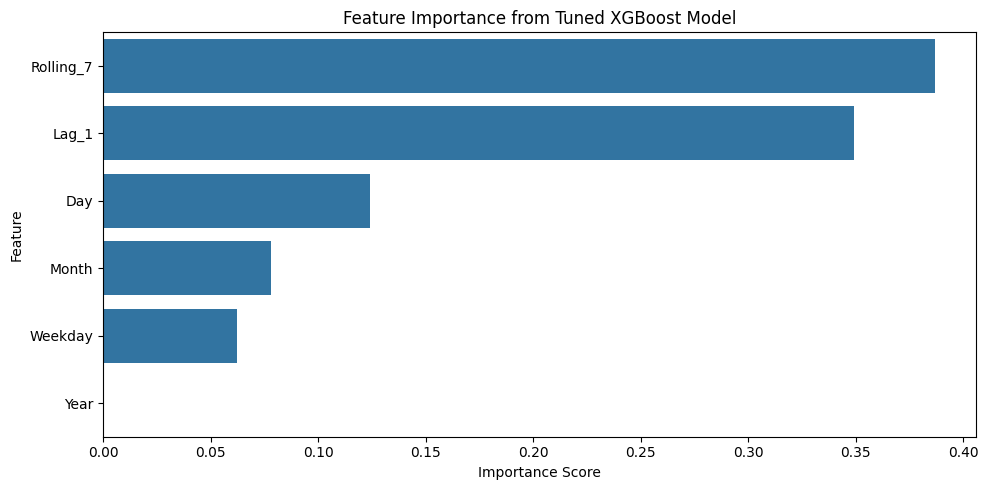

In [ ]:
# Use X_train_raw to get feature names
feature_importance = pd.Series(
    best_xgb.feature_importances_,
    index=X_train_raw.columns  # not X_train (which is now a NumPy array)
).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance from Tuned XGBoost Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# **Top-Selling Products by SKU and Category**

To help guide stocking and promotional decisions, we identify the top-selling products from two angles:

- **SKU-level performance**: Unique products that generate the most quantity sold or revenue
- **Category-level performance**: Broader product group trends

This helps target both individual high performers and entire successful categories.


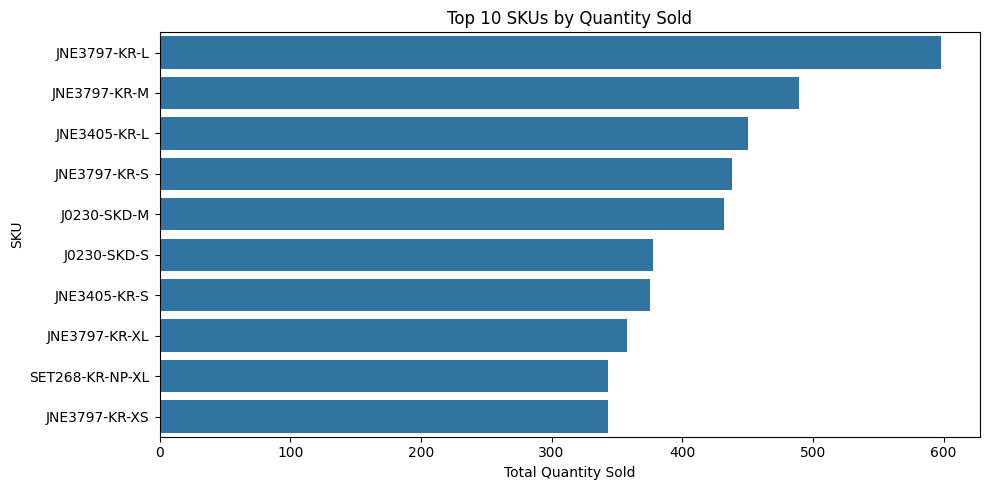

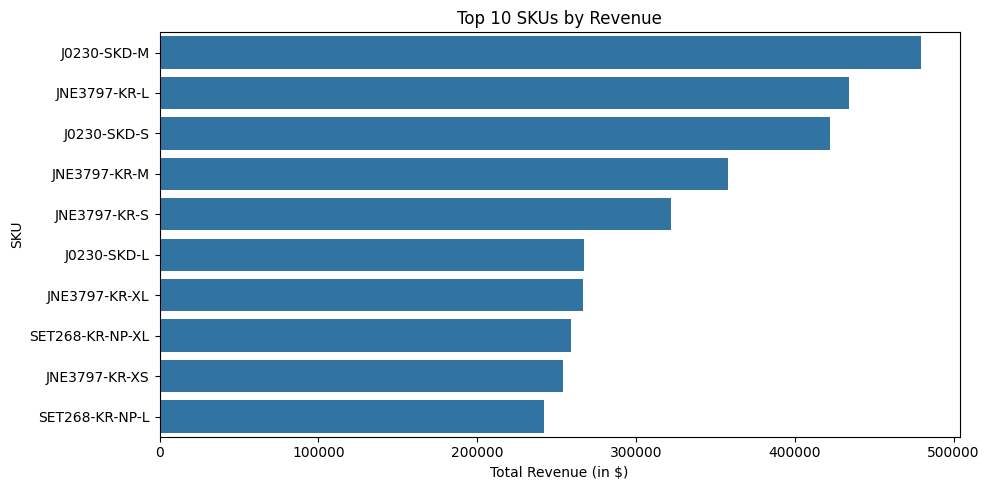

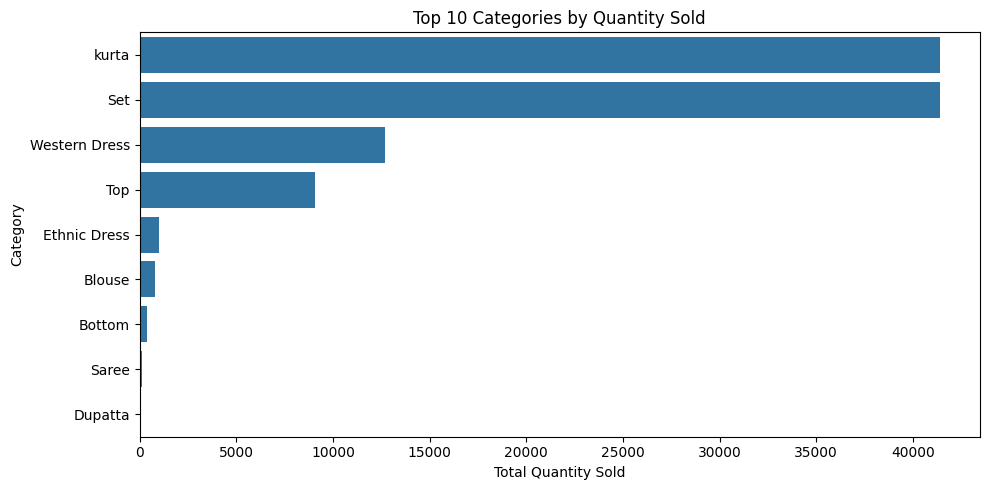

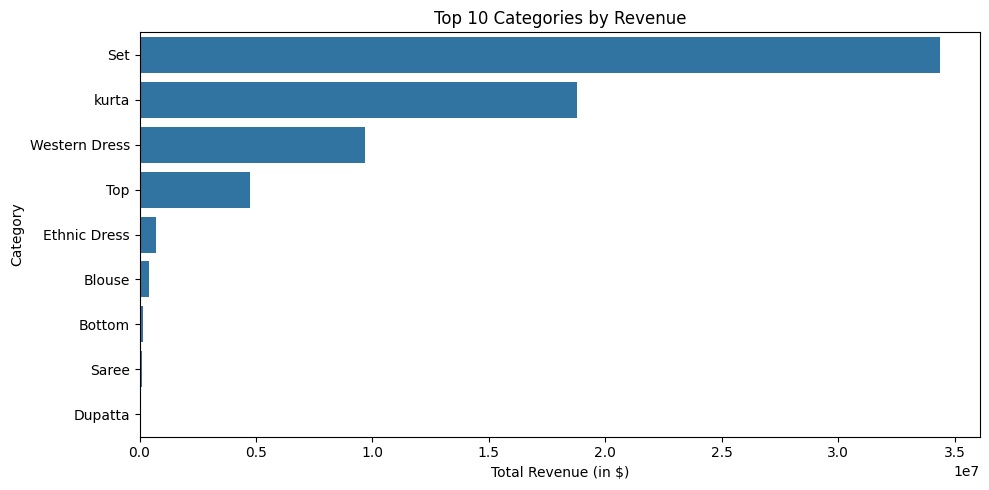

In [ ]:
# Top Products by SKU
top_sku = df.groupby('SKU').agg({
    'Qty': 'sum',
    'Amount': 'sum'
}).sort_values(by='Qty', ascending=False)

top_sku_by_qty = top_sku.sort_values(by='Qty', ascending=False).head(10)
top_sku_by_revenue = top_sku.sort_values(by='Amount', ascending=False).head(10)

# Top Products by Category
top_cat = df.groupby('Category').agg({
    'Qty': 'sum',
    'Amount': 'sum'
}).sort_values(by='Qty', ascending=False)

top_cat_by_qty = top_cat.sort_values(by='Qty', ascending=False).head(10)
top_cat_by_revenue = top_cat.sort_values(by='Amount', ascending=False).head(10)

# Plots — Top 10 SKUs
plt.figure(figsize=(10, 5))
sns.barplot(x=top_sku_by_qty['Qty'], y=top_sku_by_qty.index)
plt.title("Top 10 SKUs by Quantity Sold")
plt.xlabel("Total Quantity Sold")
plt.ylabel("SKU")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=top_sku_by_revenue['Amount'], y=top_sku_by_revenue.index)
plt.title("Top 10 SKUs by Revenue")
plt.xlabel("Total Revenue (in $)")
plt.ylabel("SKU")
plt.tight_layout()
plt.show()

# Plots — Top 10 Categories
plt.figure(figsize=(10, 5))
sns.barplot(x=top_cat_by_qty['Qty'], y=top_cat_by_qty.index)
plt.title("Top 10 Categories by Quantity Sold")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=top_cat_by_revenue['Amount'], y=top_cat_by_revenue.index)
plt.title("Top 10 Categories by Revenue")
plt.xlabel("Total Revenue (in $)")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


# **Daily Sales Pattern Analysis**

Since our dataset contains data only from **April 2022**, we analyze sales behavior by **day of the month** and **day of the week**.

This helps us:
- Spot daily demand fluctuations
- Identify which weekdays are more profitable
- Recommend specific days for promotional or operational focus


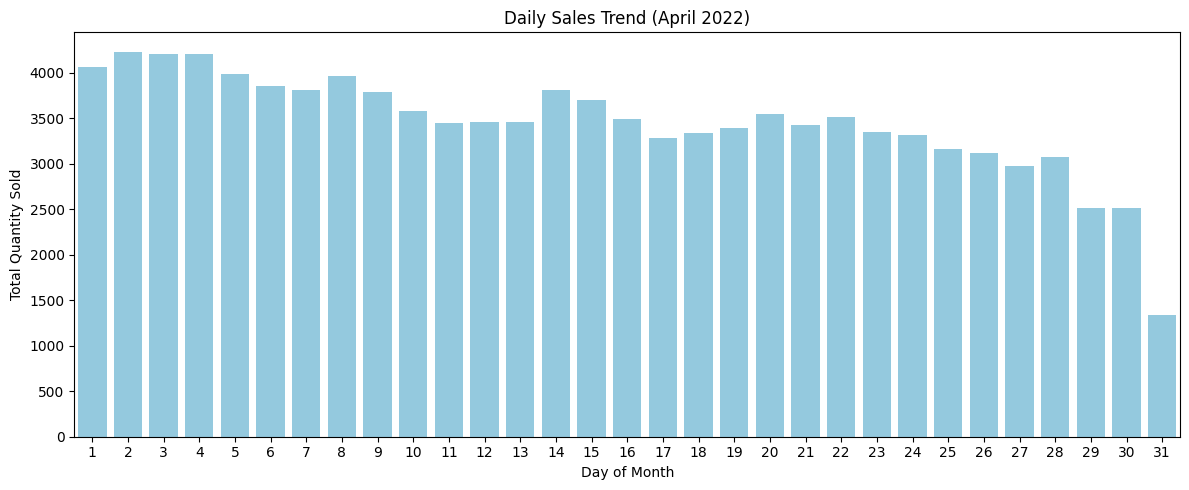

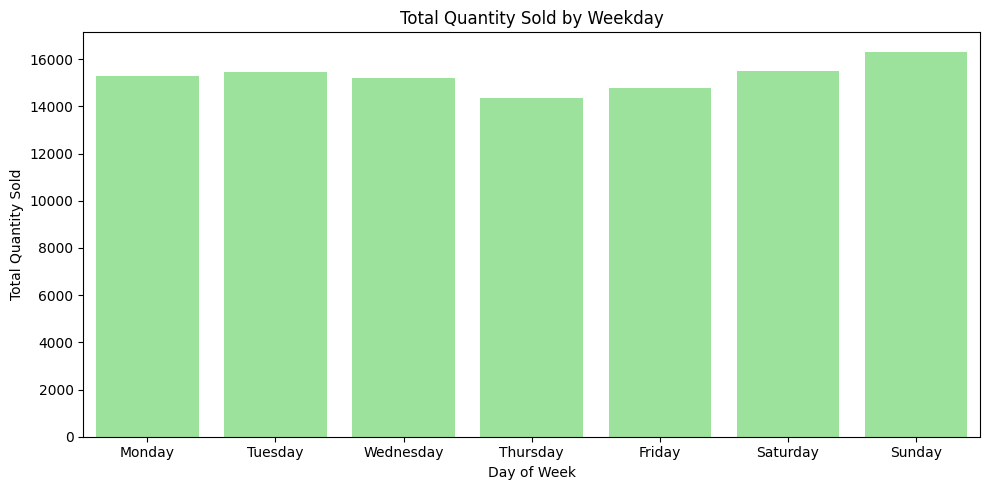

In [ ]:
# Extract day of month and weekday
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.day_name()

# Aggregate sales by day
day_wise_qty = df.groupby('Day')['Qty'].sum().reset_index()
weekday_qty = df.groupby('Weekday')['Qty'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).reset_index()

# Plot day-wise sales
plt.figure(figsize=(12, 5))
sns.barplot(data=day_wise_qty, x='Day', y='Qty', color='skyblue')
plt.title("Daily Sales Trend (April 2022)")
plt.xlabel("Day of Month")
plt.ylabel("Total Quantity Sold")
plt.tight_layout()
plt.show()

# Plot weekday sales
plt.figure(figsize=(10, 5))
sns.barplot(data=weekday_qty, x='Weekday', y='Qty', color='lightgreen')
plt.title("Total Quantity Sold by Weekday")
plt.xlabel("Day of Week")
plt.ylabel("Total Quantity Sold")
plt.tight_layout()
plt.show()


## **Shop Closure Signal Detection – Bottom 5 Days (April 2022)**

To simulate when a shop might consider closing or reducing operations, we analyze the **least active sales days**.
# New Section
Since there were no zero-sale days, we instead visualize the **bottom 5 sales days** based on total quantity sold.

This helps:
- Detect operational slowdowns
- Avoid expansion during low-traffic days
- Consider future pause or cost-saving strategies on low-performing dates


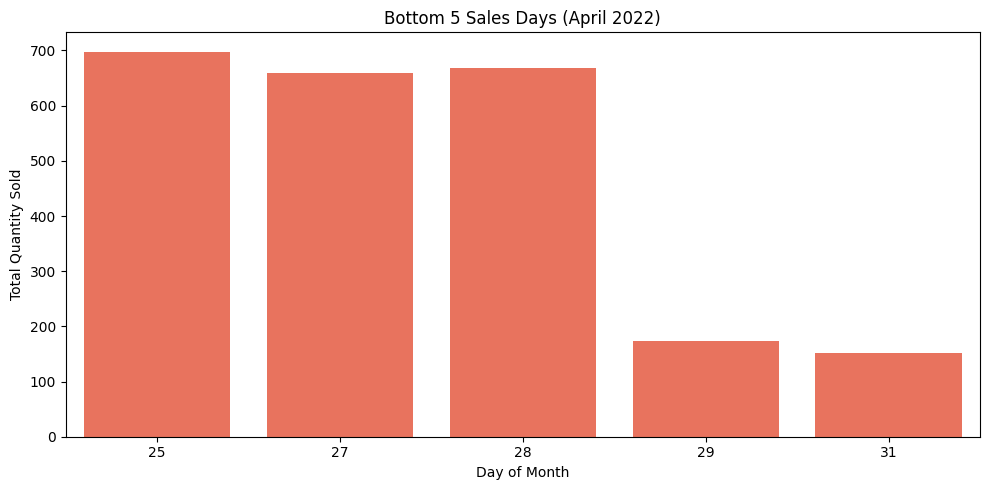

In [ ]:
# Daily total quantity sold
daily_totals = df.groupby('Date')['Qty'].sum().reset_index()

# Bottom 5 days by sales
bottom_5_days = daily_totals.sort_values(by='Qty').head(5)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=bottom_5_days['Date'].dt.day, y=bottom_5_days['Qty'], color='tomato')
plt.title("Bottom 5 Sales Days (April 2022)")
plt.xlabel("Day of Month")
plt.ylabel("Total Quantity Sold")
plt.tight_layout()
plt.show()


# **Interpretation: Bottom 5 Sales Days**

The bar chart above highlights the **5 lowest-performing days** of April 2022 in terms of quantity sold.

#### Insights:
- These dates reflect potential periods of **low customer engagement or demand**
- Such dips may suggest **inefficient inventory use**, **poor promotion**, or **natural market behavior** (e.g., weekdays vs. weekends)

#### Business Implication:
- If this low-activity pattern repeats across months, these days might be **less ideal for operations or promotions**
- Future shop openings should **avoid aligning with these weak traffic patterns** unless demand can be stimulated

We use this insight to flag potential **non-viable time windows** for retail activity.


# **Forecasting Future Sales (Next 14 Days)**

We use the trained **Linear Regression** model to forecast sales for the next two weeks.

To do this, we:
- Extend the date range by 14 days
- Generate features (lag, rolling average, date parts) for those future dates
- Use the model to predict daily quantity sold

This gives the business a **data-driven estimate of short-term demand**, useful for staffing, inventory planning, and promotions.


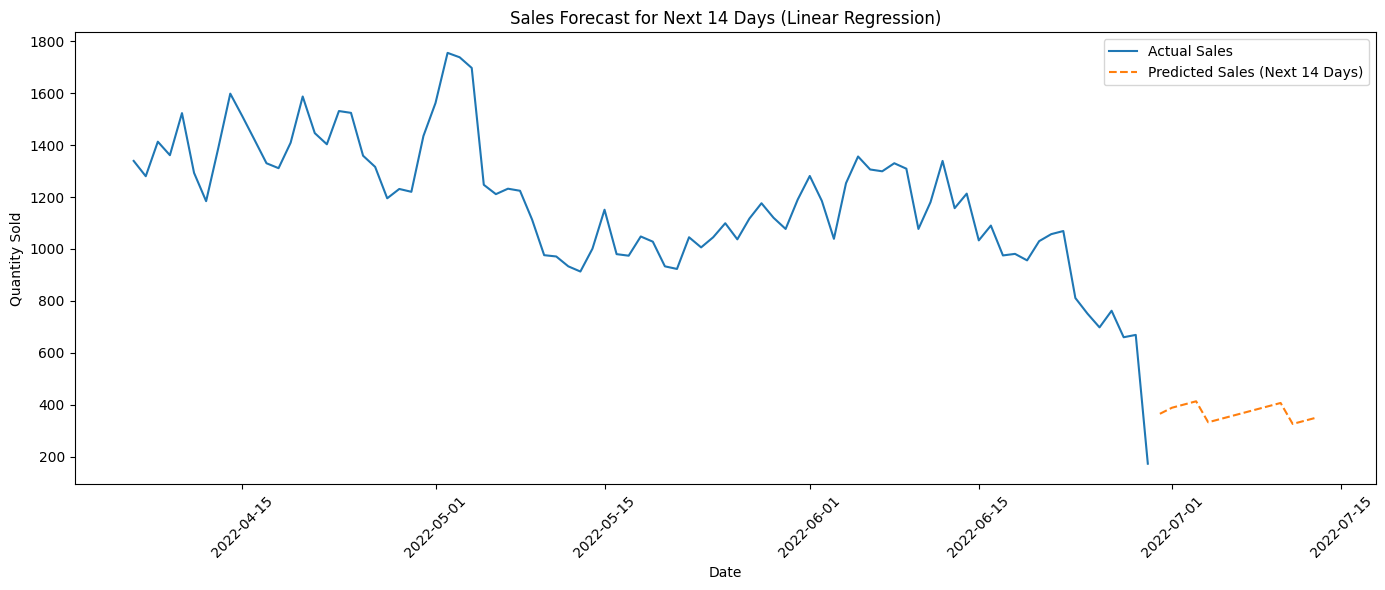

In [ ]:
from datetime import timedelta
import matplotlib.pyplot as plt
import pandas as pd


last_date = daily_sales['Date'].max()


future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=14)


future_df = pd.DataFrame({'Date': future_dates})


future_df['Lag_1'] = daily_sales['Total_Qty'].iloc[-1]

# Rolling average from last 7 days
rolling_avg = daily_sales['Total_Qty'].tail(7).mean()
future_df['Rolling_7'] = rolling_avg


future_df['Day'] = future_df['Date'].dt.day
future_df['Weekday'] = future_df['Date'].dt.weekday
future_df['Month'] = future_df['Date'].dt.month
future_df['Year'] = future_df['Date'].dt.year


future_features = future_df[['Lag_1', 'Rolling_7', 'Day', 'Weekday', 'Month', 'Year']]


future_scaled = scaler.transform(future_features)

# Predict using trained Linear Regression model
future_preds = models['Linear Regression'].predict(future_scaled)
future_df['Predicted_Qty'] = future_preds

# Plot historical + predicted sales
plt.figure(figsize=(14, 6))
plt.plot(daily_sales['Date'], daily_sales['Total_Qty'], label='Actual Sales')
plt.plot(future_df['Date'], future_df['Predicted_Qty'], label='Predicted Sales (Next 14 Days)', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.title("Sales Forecast for Next 14 Days (Linear Regression)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## **Forecast Curve Interpretation – Linear Regression (Next 14 Days)**

The plot above combines:
- **Actual historical daily sales** (solid line)
- **Predicted daily sales for the next 14 days** (dashed line)

####  Observations:
- The forecast shows a **smooth and stable trend**, consistent with the recent historical average
- No sudden demand spikes or drops are expected
- This reflects **steady consumer behavior**, with low volatility in short-term demand

#### Business Recommendations:
- Maintain **baseline inventory and staffing levels** — no need for surge adjustments
- Avoid launching large-scale marketing or operational changes during this period
- Use this calm phase to focus on **restocking**, **training**, or **process improvements**

Overall, the forecast supports a strategy of **stability and operational efficiency**, rather than aggressive expansion or scale-down.


# **Final Project Summary: Amazon Retail Sales Forecasting**

This project focuses on **predicting and analyzing daily retail sales** using a real-world Amazon sales dataset. The objective was not only to build predictive models but also to extract actionable business insights from sales patterns.

---

## Objectives
- Forecast short-term daily sales using machine learning models
- Identify top-selling products and categories
- Recommend ideal times for shop openings
- Detect low-demand periods (closure signals)
- Support data-driven retail planning

---

## Key Steps & Findings

### 1. Data Cleaning & Feature Engineering
- Parsed transaction data and handled missing dates
- Aggregated daily sales
- Engineered lag and rolling features (e.g., `Lag_1`, `Rolling_7`)
- Extracted calendar components (day, weekday, month, year)

---

### 2. Model Training & Evaluation
We trained and evaluated multiple regression models:

| Model              | MAE    | RMSE   |
|--------------------|--------|--------|
| **Linear Regression** | **119.17** | **164.91** ✅ Best performer |
| K-Nearest Neighbors | 187.72 | 269.33 |
| Random Forest       | 218.83 | 309.17 |
| Decision Tree       | 224.18 | 303.58 |
| XGBoost (tuned)     | 230.68 | 325.82 |
| SVR                 | 348.15 | 425.74 |

**Linear Regression performed best**, indicating a strong linear trend in the data.

---

### 3. Top-Selling Product Insights
- Identified top 10 SKUs and categories by both **quantity sold** and **revenue**
- Helps prioritize inventory and marketing efforts

---

### 4. Shop Opening Recommendation
- Tried month-wise trend analysis, but dataset only had April 2022
- Switched to daily and weekday pattern analysis
- Found specific **days of the week** with higher engagement (ideal for promotions)

---

### 5. Shop Closure Signal Detection
- No zero-sale days found
- Identified **bottom 5 low-performance days** in April
- Useful for detecting slow periods or optimizing operations

---

### 6. Future Sales Forecast (Next 14 Days)
- Used Linear Regression to predict sales
- Forecast showed **stable short-term demand**, no major spikes
- Recommendation: maintain steady operations without scaling aggressively

---

## Conclusion

This project demonstrated:
- A complete end-to-end machine learning pipeline
- Real-world business insights using both statistical and predictive methods
- How data science can guide **inventory**, **staffing**, and **strategic planning**

 **Linear Regression** proved to be the most reliable model for this dataset.

---

